In [1]:
#Trabalho final
#Disciplina: Estatística Descritiva
#Objetivo: Análise da base de dados das unidades básicas de saúde em todo o território brasileiro
#MBA de Ciência de Dados e IA da ENAP
#Março/2025
#Aluna: Renata Rocha Torres Amaral
#Professor: Stefano Mozart

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gmean, hmean, skew, kurtosis, lognorm, kendalltau
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.regression.quantile_regression import QuantReg

In [3]:
# Definir o nome do arquivo CSV
arquivo_csv = "ubs_brasil.csv"

# Carregar o arquivo CSV em um DataFrame, tratando células em branco como NaN
try:
    df_ubs_brasil = pd.read_csv(
        arquivo_csv,
        encoding="utf-8",
        delimiter=';',  # Usar delimitador de ponto e vírgula
        decimal=',',  # Definir vírgula como separador decimal
        dtype={"CNES": str, "UF": str, "IBGE": str},  # Definir colunas como string
        na_values=['']  # Tratar células em branco como NaN
    )

     # Adicionar a coluna "qtd" com valor 1 para cada linha
    df_ubs_brasil["qtd"] = 1
    print("Arquivo carregado com sucesso!")
    display(df_ubs_brasil.head())  # Exibir as primeiras linhas do DataFrame
except FileNotFoundError:
    print(f"Erro: O arquivo '{arquivo_csv}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao carregar o arquivo: {e}")

Arquivo carregado com sucesso!


,CNES,UF,IBGE,NOME,LOGRADOURO,BAIRRO,LATITUDE,LONGITUDE,qtd
0,0000302,26,260290,USF SANTO ESTEVAO,RUA DO CEMITERIO,PONTE DOS CARVALHOS,-8.21811,-35.22944,1
1,2376210,50,500240,ESTRATEGIA DE SAUDE DA FAMILIA MARIZA RODRIGUE...,RUA JOAO PESSOA,SANTO ANTONIO,-22.61912,-54.83528,1
2,2789310,35,355030,UBS VILA COSMOPOLITA,RUA CHUVAS DE VERAO,GUAIANASES,-23.56096,-46.42381,1
3,4613902,21,211060,POSTO MORRO DO SALTO DA PEDRA,POVOADO MORRO DO SALTO DA PEDRA,ZONA RURAL,-3.42166,-42.36826,1
4,4613910,21,211060,POSTO ENXU,POVOADO ENXU,ZONA RURAL,-3.32356,-42.58953,1


In [4]:
# Carregar o arquivo Excel, ignorando a primeira linha e tratando as colunas "COD. UF" e "COD. MUNIC" como string
df_pop = pd.read_excel("populacao.xls", skiprows=1, dtype={"COD. UF": str, "COD. MUNIC": str})

# Renomear a coluna "POPULAÇÃO APURADA IBGE - CENSO DEMOGRÁFICO 2022 E MALHA TERRITORIAL 2023 -" para "pop"
df_pop = df_pop.rename(columns={"POPULAÇÃO APURADA IBGE \n- CENSO DEMOGRÁFICO 2022 E MALHA TERRITORIAL 2023 -": "pop"})

# Converter a coluna "pop" para tipo inteiro
df_pop["pop"] = pd.to_numeric(df_pop["pop"], errors='coerce').fillna(0).astype(int)

# Excluir as últimas 34 linhas
df_pop = df_pop.iloc[:-34]

# Criar a coluna "IBGE6" como a concatenação de "COD. UF" e "COD. MUNIC"
df_pop["IBGE6"] = (df_pop["COD. UF"] + df_pop["COD. MUNIC"]).str[:-1]  # Excluir o último caractere

# Exibir as primeiras linhas para verificação
df_pop.head()

,UF,COD. UF,COD. MUNIC,NOME DO MUNICÍPIO,pop,IBGE6
0,RO,11,00015,Alta Floresta D'Oeste,21494,110001
1,RO,11,00023,Ariquemes,96833,110002
2,RO,11,00031,Cabixi,5351,110003
3,RO,11,00049,Cacoal,86887,110004
4,RO,11,00056,Cerejeiras,15890,110005


In [5]:
# Garantir que as colunas usadas na mesclagem sejam do tipo string
df_ubs_brasil["IBGE"] = df_ubs_brasil["IBGE"].astype(str)
df_pop["IBGE6"] = df_pop["IBGE6"].astype(str)

# Selecionar apenas a coluna desejada do df_pop
df_pop_selecionado = df_pop[["IBGE6", "pop"]]

# Mesclar os DataFrames usando as colunas "IBGE" e "IBGE6"
df_ubs = df_ubs_brasil.merge(df_pop_selecionado, left_on="IBGE", right_on="IBGE6", how="left")

# Garantir que a coluna 'pop' seja do tipo inteiro sem casa decimal
df_ubs["pop"] = pd.to_numeric(df_ubs["pop"], errors='coerce').fillna(0).astype(int)


# Exibir as primeiras linhas do DataFrame mesclado
df_ubs.head()



,CNES,UF,IBGE,NOME,LOGRADOURO,BAIRRO,LATITUDE,LONGITUDE,qtd,IBGE6,pop
0,0000302,26,260290,USF SANTO ESTEVAO,RUA DO CEMITERIO,PONTE DOS CARVALHOS,-8.21811,-35.22944,1,260290,203440
1,2376210,50,500240,ESTRATEGIA DE SAUDE DA FAMILIA MARIZA RODRIGUE...,RUA JOAO PESSOA,SANTO ANTONIO,-22.61912,-54.83528,1,500240,30612
2,2789310,35,355030,UBS VILA COSMOPOLITA,RUA CHUVAS DE VERAO,GUAIANASES,-23.56096,-46.42381,1,355030,11451999
3,4613902,21,211060,POSTO MORRO DO SALTO DA PEDRA,POVOADO MORRO DO SALTO DA PEDRA,ZONA RURAL,-3.42166,-42.36826,1,211060,26943
4,4613910,21,211060,POSTO ENXU,POVOADO ENXU,ZONA RURAL,-3.32356,-42.58953,1,211060,26943


In [6]:
# Exibir as variáveis disponíveis no DataFrame
print("Variáveis disponíveis no DataFrame:")
print(df_ubs.columns.tolist())

Variáveis disponíveis no DataFrame:
['CNES', 'UF', 'IBGE', 'NOME', 'LOGRADOURO', 'BAIRRO', 'LATITUDE', 'LONGITUDE', 'qtd', 'IBGE6', 'pop']


In [7]:
# Identificar o tipo de cada variável
print("\nTipo de cada variável:")
for coluna in df_ubs.columns:  # Use df_ubs agora
    tipo = ""
    if df_ubs[coluna].dtype == "object":
        tipo = "Qualitativa Nominal"
    elif df_ubs[coluna].dtype in ["int64", "int32"]:
        tipo = "Quantitativa Discreta"
    elif df_ubs[coluna].dtype in ["float64", "float32"]:
        tipo = "Quantitativa Contínua"
    print(f"{coluna}: {tipo}")



Tipo de cada variável:
CNES: Qualitativa Nominal
UF: Qualitativa Nominal
IBGE: Qualitativa Nominal
NOME: Qualitativa Nominal
LOGRADOURO: Qualitativa Nominal
BAIRRO: Qualitativa Nominal
LATITUDE: Quantitativa Contínua
LONGITUDE: Quantitativa Contínua
qtd: Quantitativa Discreta
IBGE6: Qualitativa Nominal
pop: Quantitativa Discreta


In [8]:
# Agrupar por 'IBGE', somando a coluna 'qtd' e mantendo a coluna 'pop' (com a primeira ocorrência)
df_agrupado = df_ubs.groupby('IBGE').agg(
    qtd=('qtd', 'sum'),  # Somar a coluna 'qtd'
    pop=('pop', 'first')  # Trazer o valor da coluna 'pop' da primeira linha de cada grupo
).reset_index()  # Resetar o índice para que 'IBGE' não seja mais o índice do DataFrame

# Exibir as primeiras linhas do novo DataFrame
df_agrupado.head()


,IBGE,qtd,pop
0,110001,4,21494
1,110002,14,96833
2,110003,3,5351
3,110004,15,86887
4,110005,6,15890


In [10]:
# Exibir a distribuição de frequência para cada variável no df_agrupado
for coluna in df_agrupado.columns:
    print(f"\nDistribuição de Frequência para a coluna '{coluna}':")
    
    # Se a coluna for qualitativa (do tipo objeto ou string)
    if df_agrupado[coluna].dtype == "object":
        print(df_agrupado[coluna].value_counts())
    # Se a coluna for quantitativa (do tipo numérico)
    else:
        print(df_agrupado[coluna].describe())



Distribuição de Frequência para a coluna 'IBGE':
IBGE
530040    1
110001    1
110002    1
110003    1
110004    1
         ..
110015    1
110014    1
110013    1
110012    1
110011    1
Name: count, Length: 5482, dtype: int64

Distribuição de Frequência para a coluna 'qtd':
count    5482.000000
mean        8.525903
std        15.852338
min         1.000000
25%         2.000000
50%         5.000000
75%        10.000000
max       624.000000
Name: qtd, dtype: float64

Distribuição de Frequência para a coluna 'pop':
count    5.482000e+03
mean     3.605985e+04
std      2.046401e+05
min      0.000000e+00
25%      5.172750e+03
50%      1.101500e+04
75%      2.450575e+04
max      1.145200e+07
Name: pop, dtype: float64


In [30]:
# Calcular a moda, média e mediana da coluna 'qtd'
moda = df_agrupado['qtd'].mode()[0]  # O [0] é para pegar o primeiro valor da moda caso haja mais de uma
media = df_agrupado['qtd'].mean()
mediana = df_agrupado['qtd'].median()

# Exibir os resultados
print(f"Moda: {moda}")
print(f"Média: {media:.2f}")
print(f"Mediana: {mediana}")

Moda: 2
Média: 8.53
Mediana: 5.0


In [32]:
#A média de UBS por município é aproximadamente 8,53.

#O desvio padrão é aproximadamente 15,85, o que é relativamente grande em relação à média.
#Isso indica que a quantidade de UBS por MUN é muito dispersa e há uma variação considerável entre os valores.

#O valor mínimo registrado na coluna é 1. O que não quer dizer que todos os municípios do Brasil tem uma UBS.
#Nem todos os municípios tem UBS. 5482 municípios tem UBS de um total de 5570 municípios brasileiros

#O percentil 25% (primeiro quartil) é 2. Isso significa que 25% dos valores de qtd são menores ou iguais a 2.
#Mas 2 é o número que mais se repete na amostra, sendo assim, a moda.

#O percentil 50% (mediana) é 5, o que significa que metade dos valores são menores ou iguais a 5, e metade são maiores ou iguais a 5.
#Isso pode significar uma Distribuição assimétrica. A mediana (5) é consideravelmente menor que a média (8,53), o que indica uma distribuição assimétrica à direita (skewed to the right). 
#Ou seja, a distribuição tem uma cauda mais longa à direita, possivelmente devido à presença de outliers ou valores muito altos.

#O percentil 75% (terceiro quartil) é 10. Isso indica que 75% dos valores são menores ou iguais a 10, e os 25% restantes são maiores que 10.

#O valor máximo é 624. Isso é consideravelmente maior que a média e os percentis, o que sugere a presença de alguns valores extremos ou outliers. 
#Ou seja, há registros com valores de qtd muito elevados, o que está influenciando a grande variação do desvio padrão.

#Com os dados, infere-se que há desbalanceamento dos dados,principalmente devido à distribuição assimétrica.
#Como estou analisando a distribuição de UBS no Brasil, não vou tratar os casos extremos como outlier.

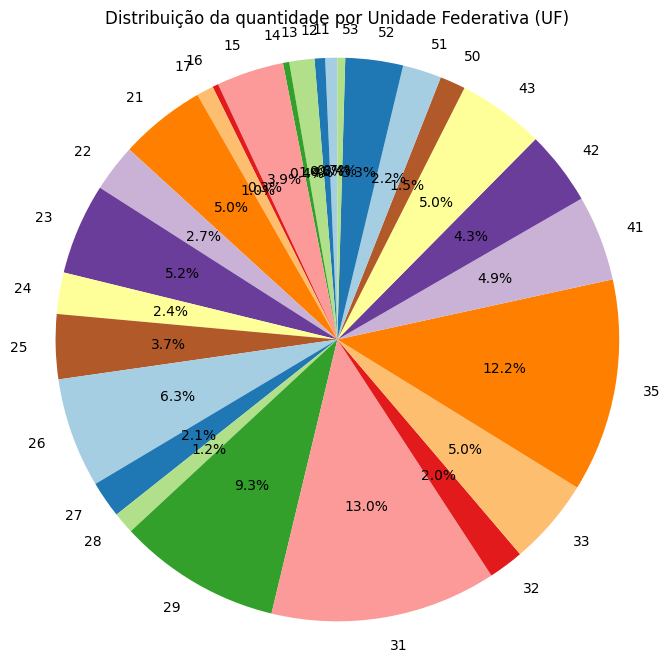

In [16]:
# Criar a coluna UF com os dois primeiros caracteres da coluna IBGE
df_agrupado['UF'] = df_agrupado['IBGE'].str[:2]

# Agrupar o DataFrame por UF e somar a coluna 'qtd'
uf_counts = df_agrupado.groupby('UF')['qtd'].sum()

# Criar o gráfico de pizza com a soma de 'qtd' por 'UF'
plt.figure(figsize=(8, 8))
plt.pie(uf_counts, labels=uf_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title("Distribuição da quantidade por Unidade Federativa (UF)")
plt.axis('equal')  # Garantir que o gráfico seja um círculo
plt.show()


In [17]:
#Considerando que são 27 unidades da federação, o gráfico acima não traz uma boa visualização dos dados.

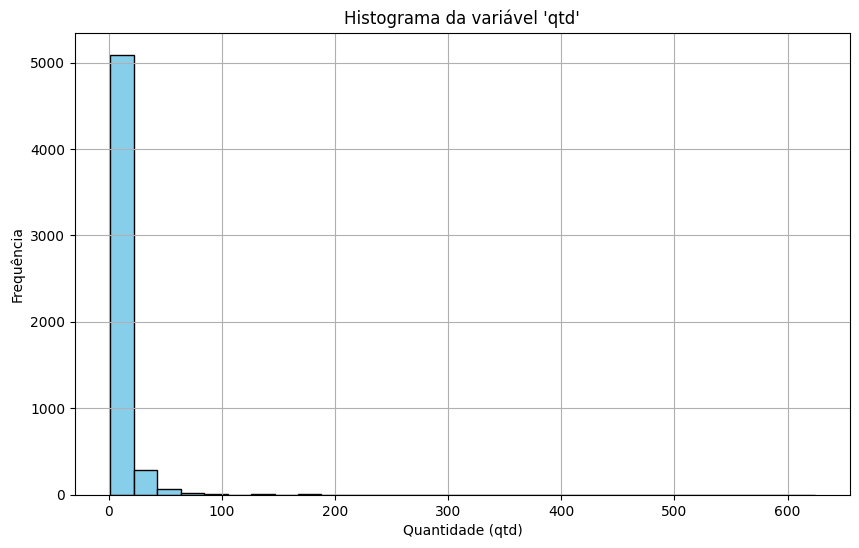

In [18]:
# Exibir o histograma da variável 'qtd'
plt.figure(figsize=(10, 6))
df_agrupado['qtd'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title("Histograma da variável 'qtd'")
plt.xlabel("Quantidade (qtd)")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()


Limite inferior: -10.0
Limite superior: 22.0

Outliers abaixo do limite inferior:
Empty DataFrame
Columns: [IBGE, qtd, pop, UF, faixa_qtd]
Index: []

Outliers acima do limite superior:
        IBGE  qtd      pop  UF    faixa_qtd
16    110020   60        0  11  Acima de 32
57    120020   29    91888  12      29 a 31
66    120040  106   364756  12  Acima de 32
109   130260  255  2063689  13  Acima de 32
119   130353   23    30668  13      23 a 25
...      ...  ...      ...  ..          ...
5446  521975   23    72127  52      23 a 25
5457  522045   24   155635  52      23 a 25
5466  522140   32   142431  52  Acima de 32
5474  522185   39   198861  52  Acima de 32
5480  530010  207        0  53  Acima de 32

[360 rows x 5 columns]


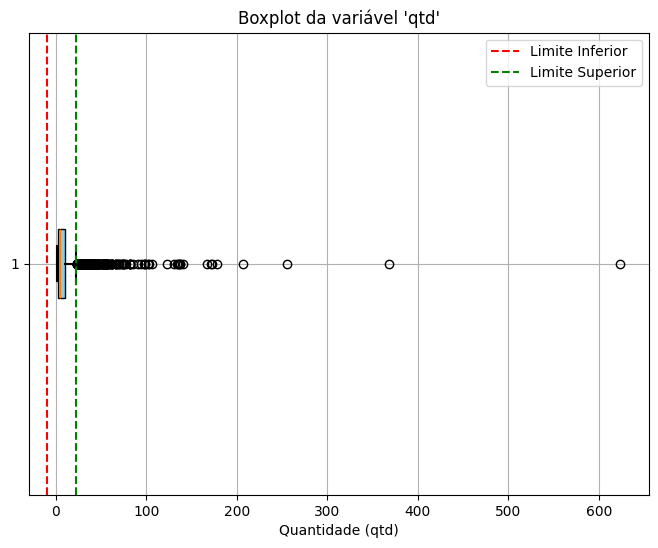

In [39]:
# Calcular os quartis e o IQR para a coluna 'qtd'
Q1 = df_agrupado['qtd'].quantile(0.25)
Q3 = df_agrupado['qtd'].quantile(0.75)
IQR = Q3 - Q1

# Calcular os limites inferior e superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar os valores fora dos limites (outliers)
outliers_abaixo = df_agrupado[df_agrupado['qtd'] < limite_inferior]
outliers_acima = df_agrupado[df_agrupado['qtd'] > limite_superior]

# Exibir os resultados dos limites e dos outliers
print(f"Limite inferior: {limite_inferior}")
print(f"Limite superior: {limite_superior}")
print(f"\nOutliers abaixo do limite inferior:\n{outliers_abaixo}")
print(f"\nOutliers acima do limite superior:\n{outliers_acima}")

# Criar o Boxplot para a variável 'qtd'
plt.figure(figsize=(8, 6))
plt.boxplot(df_agrupado['qtd'], vert=False, patch_artist=True, 
            boxprops=dict(facecolor='skyblue', color='black'),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5))

# Adicionar linhas para o limite inferior e superior
plt.axvline(limite_inferior, color='red', linestyle='--', label='Limite Inferior')
plt.axvline(limite_superior, color='green', linestyle='--', label='Limite Superior')

# Título e rótulos
plt.title("Boxplot da variável 'qtd'")
plt.xlabel("Quantidade (qtd)")
plt.grid(True)

# Exibir a legenda
plt.legend()

# Mostrar o gráfico
plt.show()


In [27]:
# Definir os intervalos de quantidade com as novas faixas
bins = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 22, 25, 28, 31, float('inf')]  # Novas faixas
labels = ['0 a 1', '2 a 3', '4 a 5', '6 a 7', '8 a 9', '10 a 11', '12 a 13', '14 a 15', '16 a 17', 
          '18 a 19', '20 a 22', '23 a 25', '26 a 28', '29 a 31', 'Acima de 32']  # Novos rótulos

# Criar a coluna de faixas de quantidade no DataFrame df_agrupado
df_agrupado['faixa_qtd'] = pd.cut(df_agrupado['qtd'], bins=bins, labels=labels, right=True)

# Contar a frequência de cada faixa
frequencia = df_agrupado['faixa_qtd'].value_counts().sort_index()

# Exibir a tabela de frequência como um DataFrame
tabela_frequencia = frequencia.reset_index()
tabela_frequencia.columns = ['Faixa', 'Frequência']

# Adicionar uma linha de total
total_frequencia = frequencia.sum()

linha_total = pd.DataFrame({'Faixa': ['Total'], 'Frequência': [total_frequencia]})

# Concatenar a linha de total ao final da tabela
tabela_frequencia = pd.concat([tabela_frequencia, linha_total], ignore_index=True)

# Exibir a tabela formatada
print(tabela_frequencia)

          Faixa  Frequência
0         0 a 1         742
1         2 a 3        1346
2         4 a 5         871
3         6 a 7         640
4         8 a 9         501
5       10 a 11         313
6       12 a 13         230
7       14 a 15         172
8       16 a 17         110
9       18 a 19          89
10      20 a 22         108
11      23 a 25          74
12      26 a 28          48
13      29 a 31          53
14  Acima de 32         185
15        Total        5482


In [41]:
#No histograma, boxspot e tabela de frequência, é possível perceber claramente a distribuição assimétrica.
#Como já falando antes, por se tratar de dados reais de UBS no Brasil, não vamos tratar como outlier os valores discrepantes, pois posteriormente vou fazer uma correlação com a quantidade de pessoas por município.
#O Brasil é um país com muitos municípios e com uma grande diversidade.

In [33]:
# Calcular a média geométrica
media_geometrica = gmean(df_agrupado['qtd'])

# Calcular a média harmônica
media_harmonica = hmean(df_agrupado['qtd'])

# Exibir os resultados
print(f"Média Geométrica: {media_geometrica:.2f}")
print(f"Média Harmônica: {media_harmonica:.2f}")



Média Geométrica: 4.89
Média Harmônica: 3.11


In [34]:
#Média Geométrica = 4.89: Reflete a tendência central de uma distribuição com grandes variações.
#Média Harmônica = 3.11: Indica que há uma concentração de valores baixos em qtd, influenciando a média harmônica para valores menores.
#Esses resultados mostram que a distribuição de UBS no Brasil pode ser assimétrica e que há uma mistura de valores baixos e altos,
#com uma concentração de valores pequenos (média harmônica menor e moda baixa). 
#A média e a mediana indicam que valores mais altos têm um impacto na distribuição.

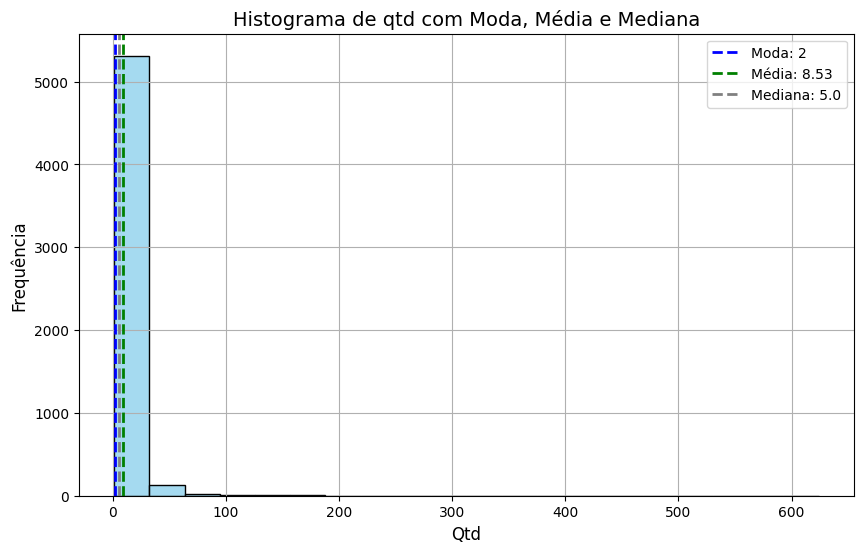

In [36]:
# Dados fictícios para ilustrar
# Aqui, 'qtd' seria a coluna do seu DataFrame
qtd = df_agrupado["qtd"]

# Cálculo dos valores de moda, média e mediana
moda = qtd.mode()[0]  # Moda
media = qtd.mean()    # Média
mediana = qtd.median()  # Mediana

# Plotando o histograma
plt.figure(figsize=(10, 6))
sns.histplot(qtd, kde=False, bins=20, color='skyblue', edgecolor='black')

# Adicionando as linhas verticais para Moda, Média e Mediana
plt.axvline(moda, color='blue', linestyle='dashed', linewidth=2, label=f'Moda: {moda}')
plt.axvline(media, color='green', linestyle='dashed', linewidth=2, label=f'Média: {media:.2f}')
plt.axvline(mediana, color='gray', linestyle='dashed', linewidth=2, label=f'Mediana: {mediana}')

# Títulos e rótulos
plt.title('Histograma de qtd com Moda, Média e Mediana', fontsize=14)
plt.xlabel('Qtd', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

# Exibindo a legenda
plt.legend()

# Exibindo o gráfico
plt.grid(True)
plt.show()


In [42]:
# Calcular as medidas de dispersão para a variável 'qtd'
variancia = df_agrupado['qtd'].var()  # Variância
desvio_padrao = df_agrupado['qtd'].std()  # Desvio Padrão
amplitude = df_agrupado['qtd'].max() - df_agrupado['qtd'].min()  # Amplitude
Q1 = df_agrupado['qtd'].quantile(0.25)  # Primeiro quartil
Q3 = df_agrupado['qtd'].quantile(0.75)  # Terceiro quartil
IQR = Q3 - Q1  # Intervalo Interquartílico
mediana = df_agrupado['qtd'].median()  # Mediana
coef_disp_quartilico = IQR / mediana  # Coeficiente de Dispersão Quartílica
coef_variacao = (desvio_padrao / df_agrupado['qtd'].mean()) * 100  # Coeficiente de Variação

# Exibir os resultados
print(f"Variância: {variancia}")
print(f"Desvio Padrão: {desvio_padrao}")
print(f"Amplitude: {amplitude}")
print(f"Intervalo Interquartílico (IQR): {IQR}")
print(f"Coeficiente de Dispersão Quartílica: {coef_disp_quartilico}")
print(f"Coeficiente de Variação: {coef_variacao:.2f}%")


Variância: 251.29662867731653
Desvio Padrão: 15.852338271602601
Amplitude: 623
Intervalo Interquartílico (IQR): 8.0
Coeficiente de Dispersão Quartílica: 1.6
Coeficiente de Variação: 185.93%


In [43]:
#A grande amplitude, variância, desvio padrão e coeficiente de variação indicam que há uma dispersão considerável nos valores de UBS.
#Esses valores são muito altos em relação à média, o que sugere que o conjunto de dados é heterogêneo e pode haver valores extremos afetando a distribuição.
#O que está coerente com os outros resultados já obtidos.

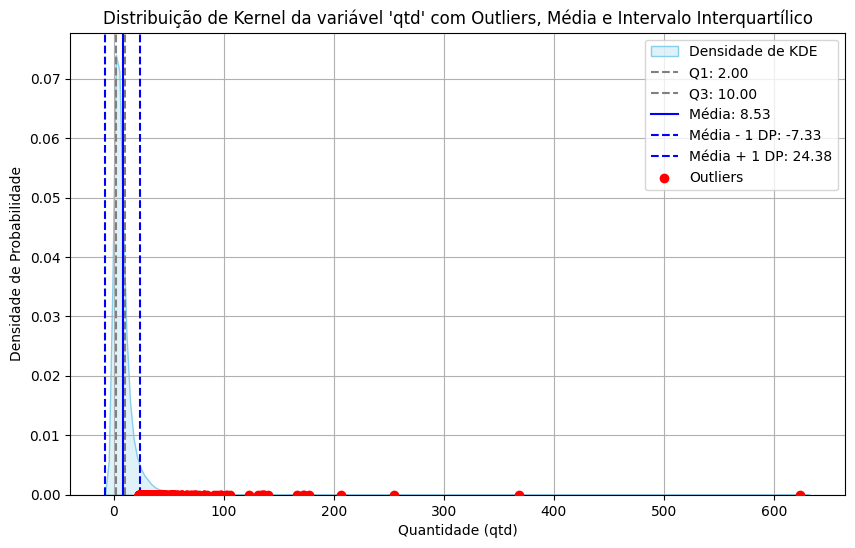

In [50]:
# Calcular Q1 (1º quartil), Q3 (3º quartil), média e desvio padrão
Q1 = df_agrupado['qtd'].quantile(0.25)
Q3 = df_agrupado['qtd'].quantile(0.75)
media = df_agrupado['qtd'].mean()
desvio_padrao = df_agrupado['qtd'].std()

# Calcular o intervalo interquartílico (IQR)
IQR = Q3 - Q1

# Definir os limites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Encontrar os outliers
outliers = df_agrupado[(df_agrupado['qtd'] < limite_inferior) | (df_agrupado['qtd'] > limite_superior)]

# Plotando o gráfico de dispersão KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(df_agrupado['qtd'], fill=True, color="skyblue", label="Densidade de KDE")

# Sinalizar o IQR (Q1 e Q3) com linhas verticais cinzas
plt.axvline(Q1, color="gray", linestyle="--", label=f"Q1: {Q1:.2f}")
plt.axvline(Q3, color="gray", linestyle="--", label=f"Q3: {Q3:.2f}")

# Sinalizar a média e o desvio padrão com linhas verticais azuis
plt.axvline(media, color="blue", linestyle="-", label=f"Média: {media:.2f}")
plt.axvline(media - desvio_padrao, color="blue", linestyle="--", label=f"Média - 1 DP: {media - desvio_padrao:.2f}")
plt.axvline(media + desvio_padrao, color="blue", linestyle="--", label=f"Média + 1 DP: {media + desvio_padrao:.2f}")

# Marcar os outliers com pontos vermelhos
plt.scatter(outliers['qtd'], np.zeros_like(outliers['qtd']), color='red', label='Outliers', zorder=5)

# Personalização do gráfico
plt.title("Distribuição de Kernel da variável 'qtd' com Outliers, Média e Intervalo Interquartílico")
plt.xlabel("Quantidade (qtd)")
plt.ylabel("Densidade de Probabilidade")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
#Nesse caso, os casos marcados são considerados apenas valores extremos.

In [52]:
# Calcular a assimetria (skewness) e a curtose (kurtosis) da variável 'qtd'
assimetria = df_agrupado['qtd'].skew()
curtose = df_agrupado['qtd'].kurt()

# Exibir os resultados
print(f"Assimetria (skewness) da variável 'qtd': {assimetria:.2f}")
print(f"Curtose (kurtosis) da variável 'qtd': {curtose:.2f}")


Assimetria (skewness) da variável 'qtd': 16.26
Curtose (kurtosis) da variável 'qtd': 493.20


In [53]:
#A assimetria é positiva e muito alta. 
#Isso significa que a distribuição da variável qtd é altamente assimétrica à direita, ou seja, a cauda da distribuição está muito mais alongada à direita. 
#Esse valor muito alto sugere que a maioria dos dados está concentrada em valores baixos, mas há alguns valores extremamente grandes que puxam a cauda da distribuição para a direita.

#A curtose é extremamente alta e positiva. 
#Isso indica que a distribuição tem caudas extremamente pesadas (muitas observações distantes da média), o que é característico de distribuições leptocúrticas. 
#A distribuição tem picos muito altos e caudas longas, o que sugere a presença de valores extremos.

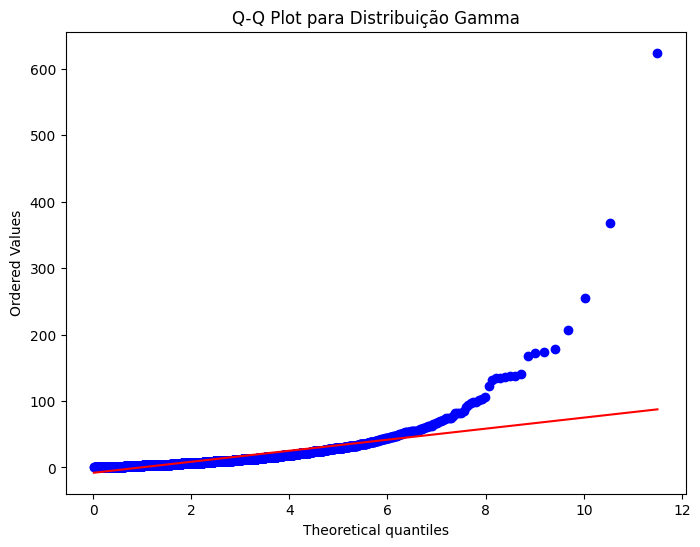

In [67]:
# Q-Q plot para verificar distribuição Gamma
plt.figure(figsize=(8, 6))
stats.probplot(df_agrupado['qtd'], dist="gamma", sparams=(2,), plot=plt)
plt.title("Q-Q Plot para Distribuição Gamma")
plt.show()

In [68]:
# Ajuste da distribuição Log-Normal aos dados
params_lognormal = stats.lognorm.fit(df_agrupado['qtd'])
print(f"Parâmetros ajustados para a distribuição Log-Normal: {params_lognormal}")


Parâmetros ajustados para a distribuição Log-Normal: (np.float64(12.9049105338056), np.float64(0.9999999999999998), np.float64(0.029650335499450627))


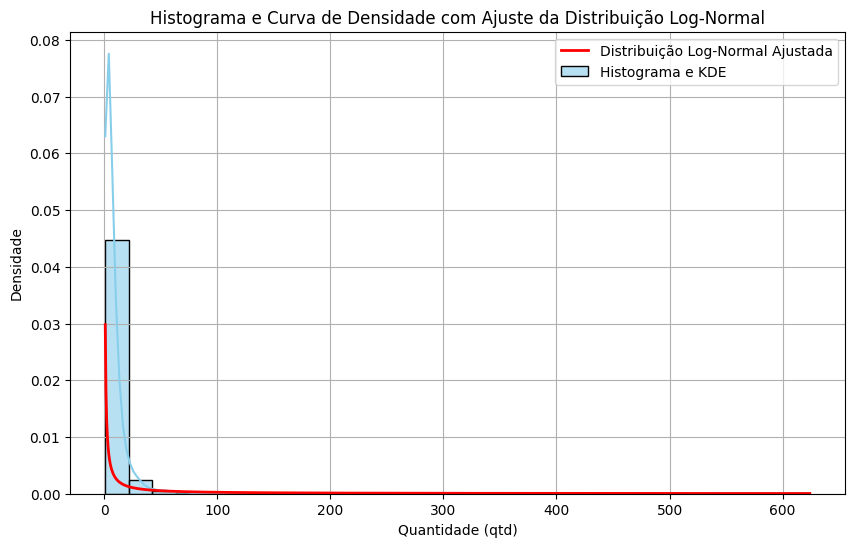

In [70]:
# Parâmetros ajustados para a distribuição Log-Normal
shape, loc, scale = 12.90, 0.00, 0.03  # Usando os valores ajustados para a distribuição

# Gerar a distribuição Log-Normal ajustada
x = np.linspace(min(df_agrupado['qtd']), max(df_agrupado['qtd']), 1000)
lognorm_dist = lognorm.pdf(x, shape, loc=loc, scale=scale)

# Plotando o histograma e a densidade de Kernel dos dados
plt.figure(figsize=(10, 6))
sns.histplot(df_agrupado['qtd'], kde=True, color="skyblue", stat="density", bins=30, label="Histograma e KDE", alpha=0.6)

# Plotando a distribuição Log-Normal ajustada
plt.plot(x, lognorm_dist, color="red", label="Distribuição Log-Normal Ajustada", linewidth=2)

# Customizações do gráfico
plt.title("Histograma e Curva de Densidade com Ajuste da Distribuição Log-Normal")
plt.xlabel("Quantidade (qtd)")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()


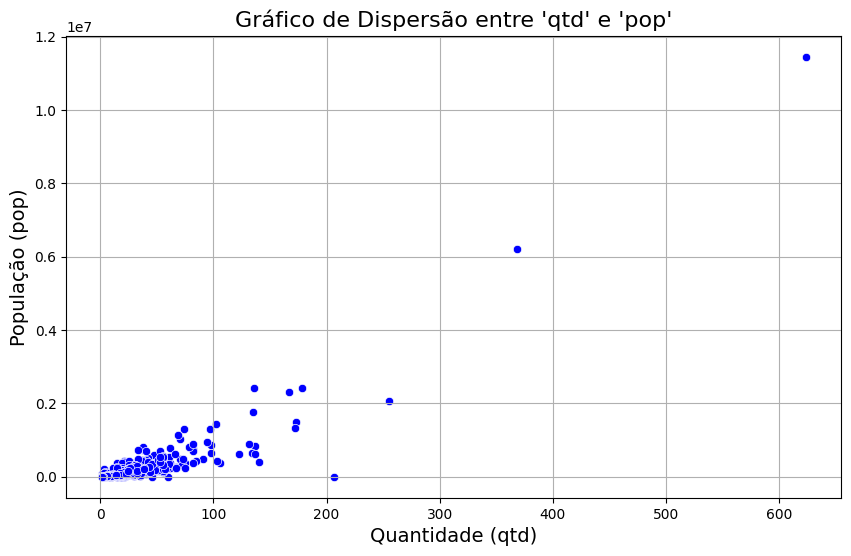

In [61]:
# Gerar o gráfico de dispersão (scatter plot) entre as variáveis 'qtd' e 'pop'
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_agrupado, x='qtd', y='pop', color='blue', marker='o')

# Adicionar título e rótulos
plt.title("Gráfico de Dispersão entre 'qtd' e 'pop'", fontsize=16)
plt.xlabel("Quantidade (qtd)", fontsize=14)
plt.ylabel("População (pop)", fontsize=14)

# Exibir o gráfico
plt.grid(True)
plt.show()

In [72]:
# Calcular a correlação de Pearson
correlacao_pearson, p_pearson = stats.pearsonr(df_agrupado['qtd'], df_agrupado['pop'])

# Calcular a correlação de Spearman
correlacao_spearman, p_spearman = stats.spearmanr(df_agrupado['qtd'], df_agrupado['pop'])

# Calcular o Coeficiente de Determinação (R²)
r_quadrado = correlacao_pearson**2

# Exibir os resultados
print(f"Correlação de Pearson: {correlacao_pearson:.4f}")
print(f"Valor p da correlação de Pearson: {p_pearson:.4f}")
print(f"Correlação de Spearman: {correlacao_spearman:.4f}")
print(f"Valor p da correlação de Spearman: {p_spearman:.4f}")
print(f"Coeficiente de Determinação (R²): {r_quadrado:.4f}")

# Interpretando os resultados
if p_pearson < 0.05:
    print("A correlação de Pearson é significativa.")
else:
    print("A correlação de Pearson não é significativa.")
    
if p_spearman < 0.05:
    print("A correlação de Spearman é significativa.")
else:
    print("A correlação de Spearman não é significativa.")


Correlação de Pearson: 0.8541
Valor p da correlação de Pearson: 0.0000
Correlação de Spearman: 0.8626
Valor p da correlação de Spearman: 0.0000
Coeficiente de Determinação (R²): 0.7294
A correlação de Pearson é significativa.
A correlação de Spearman é significativa.


In [73]:
#A correlação de Pearson de 0.8541 indica uma forte correlação positiva entre qtd e pop, ou seja, à medida que a população aumenta, a quantidade também tende a aumentar.

#A correlação de Spearman de 0.8626 também sugere uma forte associação entre qtd e pop, mas, ao contrário de Pearson, ela mede a relação monotônica (não necessariamente linear). 
#Este valor sugere que, independentemente de ser uma relação linear ou não, as variáveis estão fortemente associadas.

#Há uma forte correlação positiva entre qtd e pop, tanto em uma relação linear (correlação de Pearson) quanto monotônica (correlação de Spearman).
#Ambas as correlações são estatisticamente significativas, pois os valores p são menores que 0.05.

#O coeficiente de determinação de 0.7294 significa que 72.94% da variação na variável qtd pode ser explicada pela variação na variável pop. 
#Esse valor é bastante alto, indicando que a população tem um impacto considerável na quantidade.

In [75]:
# Supondo que o seu DataFrame seja df_agrupado com as variáveis 'qtd' e 'pop'
# Se as variáveis não estiverem em formato numérico, primeiro converta-as para numéricas:
df_agrupado['qtd'] = pd.to_numeric(df_agrupado['qtd'], errors='coerce')
df_agrupado['pop'] = pd.to_numeric(df_agrupado['pop'], errors='coerce')

# Calcular o Coeficiente de Correlação de Kendall (Tau de Kendall)
tau, p_value = kendalltau(df_agrupado['qtd'], df_agrupado['pop'])

# Exibir o resultado
print(f"Coeficiente de Correlação de Kendall (Tau de Kendall): {tau}")
print(f"Valor p: {p_value}")


Coeficiente de Correlação de Kendall (Tau de Kendall): 0.7167636641575772
Valor p: 0.0


In [76]:
#Existe uma correlação significativa e positiva entre qtd e pop, com uma força moderada a forte, conforme indicado pelo Coeficiente de Kendall (Tau de Kendall).

#A correlação é estatisticamente relevante, dado que o valor p é muito baixo (próximo de zero).

In [77]:
# Calcular a covariância entre 'qtd' e 'pop'
covariancia = df_agrupado['qtd'].cov(df_agrupado['pop'])

# Exibir o valor da covariância
print(f"Covariância entre 'qtd' e 'pop': {covariancia}")

Covariância entre 'qtd' e 'pop': 2770613.441778506


In [78]:
#A covariância entre qtd e pop é 2770613.44. 
#Isso indica uma relação positiva entre as duas variáveis, o que significa que, de maneira geral, quando a variável qtd aumenta, a variável pop também tende a aumentar, e vice-versa.

In [82]:
# Supondo que você tenha os dados 'qtd' e 'pop' no seu DataFrame
# Selecionando as variáveis contínuas
X = df_agrupado['qtd']  # Variável independente
y = df_agrupado['pop']  # Variável dependente

# Adicionando uma constante (intercepto) para o modelo de regressão OLS
X_ols = sm.add_constant(X)

# 1. Regressão OLS (Ordinary Least Squares)
ols_model = sm.OLS(y, X_ols).fit()
print("Parâmetros da Regressão OLS:")
print(ols_model.summary())

# 2. Regressão MLE (Maximum Likelihood Estimation)
# Vamos usar uma distribuição normal como exemplo
mle_model = smf.glm(formula='pop ~ qtd', data=df_agrupado, family=sm.families.Gaussian()).fit()
print("\nParâmetros da Regressão MLE:")
print(mle_model.summary())

# 3. Regressão Huber (robusta)
huber_model = RLM(y, X_ols).fit()
print("\nParâmetros da Regressão Huber:")
print(huber_model.summary())

# 4. Regressão Quantílica (Quantile Regression)
quantile_model = QuantReg(y, X_ols).fit(q=0.5)  # q=0.5 é a mediana
print("\nParâmetros da Regressão Quantílica (Mediana):")
print(quantile_model.summary())


Parâmetros da Regressão OLS:
                            OLS Regression Results                            
Dep. Variable:                    pop   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 1.477e+04
Date:                Fri, 07 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:00:04   Log-Likelihood:                -71234.
No. Observations:                5482   AIC:                         1.425e+05
Df Residuals:                    5480   BIC:                         1.425e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.794e+04  

In [ ]:
#O modelo OLS sugere que a relação entre qtd e pop é muito forte e significativa, com 72,9% da variação de pop explicada por qtd.

#O modelo MLE também mostra uma forte relação entre qtd e pop, com um pseudo R² de 0.9325, indicando uma boa adequação do modelo.

#O modelo Huber sugere que a relação entre qtd e pop é ainda mais forte em comparação ao OLS, o que pode indicar que há outliers nos dados que estão afetando os resultados do OLS.

#O modelo Quantílico reflete a relação entre qtd e pop na mediana, mas com um R² mais baixo, indicando que a relação não é tão forte no caso da mediana.

In [84]:
# Ajuste o modelo OLS com as variáveis invertidas
X = df_agrupado['pop']  # variável independente (pop - quantidade de pessoas)
X = sm.add_constant(X)  # Adicionar o intercepto ao modelo
y = df_agrupado['qtd']  # variável dependente (qtd - quantidade de UBS)

# Ajustando o modelo OLS
modelo_ols = sm.OLS(y, X).fit()

# Coeficientes do modelo (usando nomes explícitos)
intercepto = modelo_ols.params['const']  # Acessar o intercepto pela chave 'const'
coeficiente = modelo_ols.params['pop']   # Acessar o coeficiente pela chave 'pop'

# Exibir os resultados
print(f"Intercepto (β0): {intercepto}")
print(f"Coeficiente (β1): {coeficiente}")

# Função para calcular a quantidade de UBS (qtd) dado um número de pessoas (pop)
def calcular_qtd(pop):
    # A função de regressão é qtd = intercepto + coeficiente * pop
    qtd_estimado = intercepto + coeficiente * pop
    return qtd_estimado

# Exemplo de uso da função com pop = 10000 pessoas
pop_pessoas = 10000
qtd_estimado = calcular_qtd(pop_pessoas)
print(f"Para {pop_pessoas} pessoas, a quantidade estimada de UBS (qtd) é: {qtd_estimado:.2f}")




Intercepto (β0): 6.14018969478224
Coeficiente (β1): 6.615982968037487e-05
Para 10000 pessoas, a quantidade estimada de UBS (qtd) é: 6.80


In [85]:
#Considerando um cenário hipotético de que a quantidade de UBS com base na população esteja adequada, poderíamos dizer que:
#Para cada UBS instalada (qtd = 1), ela atenderia cerca de 15.064 pessoas, com base no modelo de regressão ajustado.
#Entretanto, sabemos que o cenário atual do Brasil não é perfeito, sendo praticamente impossível uma única UBS atender mais de 15.000 pessoas.

#As análises desse trabalho foram bastante interessante para fazer uma análise descritiva na base de dados, pretendo, futuramente, acrescentar mais variáveis contínuas para entender melhor o cenário para propor melhorias.